# COMP42115: Natural Language Analysis
## Sumative Assesment: Sentiment Analysis Model

In [478]:
# Importing the nescessary libraies
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sn


%matplotlib inline

from bs4 import BeautifulSoup
import re
import string
from gensim.parsing.preprocessing import remove_stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc,f1_score

from imblearn.under_sampling import RandomUnderSampler
from scipy.sparse import hstack

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow import keras
from scipy.sparse import csr_matrix


### Data preprocessing

In [479]:
# Random seed
seed = 555

In [480]:
# Loading the dataset
body = pd.read_csv('data/train_bodies.csv')
stance = pd.read_csv('data/train_stances.csv')

In [481]:
print(stance.shape)
stance.head()

(49972, 3)


,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree


In [482]:
print(body.shape)
body.head()

(1683, 2)


,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [483]:
# Merging the dataset
def merge_stance_body(stance, body):
    merged_data = pd.merge(stance, body, on='Body ID')
    return merged_data

df = merge_stance_body(stance, body)

In [484]:
train, test = train_test_split(df, test_size=0.30, random_state=seed)
train, val = train_test_split(train, test_size=0.20, random_state=seed)

In [485]:
print(train.shape)
train.head()

(27984, 4)


,Headline,Body ID,Stance,articleBody
23952,Media outlets identify 'Jihadi John',1346,discuss,THE ISLAMIC State murderer dubbed 'Jihadi John...
34151,"Rats at Vogue's NYC offices - watch your step,...",2498,agree,"In case you missed it, Vogue Magazine, one of ..."
33468,US drones hunt Isis leader in Syria,2443,discuss,There have been reports of predator drones bei...
43150,Apple Watch Gold Edition may cost as much as $...,2471,unrelated,Gill Rosenberg is reported to have been captur...
36227,HBO and Apple in Talks for $15/Month Apple TV ...,516,unrelated,A married Russian TV star woke up one day to d...


In [486]:
print(val.shape)
val.head()

(6996, 4)


,Headline,Body ID,Stance,articleBody
16486,US officials: Video shows American's execution,298,unrelated,Although Canadian police have not released the...
33030,Isilkulskom student has gained superhero power...,1503,unrelated,The internet is buzzing this morning with news...
18150,Iraqi social-media rumors claim IS leader slain,1631,unrelated,This is Sergeant-at-Arms Kevin Vickers who rep...
24707,Report: Israeli-Canadian woman fighting Islami...,2002,unrelated,BAGHDAD — Three hundred Iraqi soldiers died in...
2712,Pope Francis turns out not to have made pets i...,1905,disagree,NEW YORK — Pope Francis has given hope to gays...


In [487]:
print(test.shape)
test.head()

(14992, 4)


,Headline,Body ID,Stance,articleBody
38740,Militant Group Says It Killed American Journal...,2261,unrelated,From the midweek edition of the Morning Jolt:\...
13806,"Michael Zehaf-Bibeau, slain Ottawa shooter, ha...",186,unrelated,The sound of 10 or 11 shots from the gun of Fe...
7047,REPORT: Alleged New Audio of Michael Brown Sho...,345,unrelated,"UTAH COUNTY — Over the years, holiday office C..."
14746,Kim Jong-un Broke Both Ankles and Is Hospitali...,859,discuss,Kim Jong-Un had ankle surgery and is now recov...
49782,Report: Amazon to Launch Ad-Supported Streamin...,2442,unrelated,Google leased all 1.9 million square feet of M...


In [488]:
# Spliting the data into X, Y
def split(data):
    X = data.drop(['Body ID','Stance'], axis=1)
    Y = data['Stance']
    return X,Y

X_train, Y_train = split(train)
X_val, Y_val = split(val)
X_test, Y_test = split(test)

In [489]:
# cleaning texts
def clean_text(text):
    text = BeautifulSoup(text, "lxml").text
    text = text.replace('\n','')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    text = remove_stopwords(text)
    return text

In [490]:
def clean_data(data):
    data['Headline'] = [clean_text(i) for i in data['Headline']]
    data['articleBody'] = [clean_text(i) for i in data['articleBody']]
    return data

X_train = clean_data(X_train)
X_val = clean_data(X_val)
X_test = clean_data(X_test)

In [491]:
X_train.head()

,Headline,articleBody
23952,media outlets identify jihadi john,islamic state murderer dubbed jihadi john name...
34151,rats vogues nyc offices watch step anna wintour,case missed vogue magazine glamorous instituti...
33468,drones hunt isis leader syria,reports predator drones launched iraq reports ...
43150,apple watch gold edition cost 5000,gill rosenberg reported captured women fightin...
36227,hbo apple talks 15month apple tv streaming ser...,married russian tv star woke day discover test...


### Task 1 preparation

unrelated    20460
discuss       4993
agree         2057
disagree       474
Name: Stance, dtype: int64

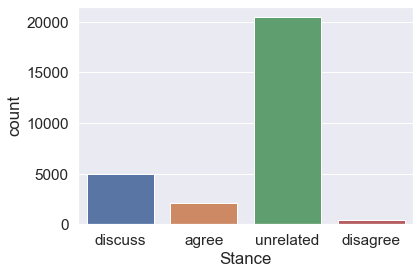

In [492]:
sn.countplot(data=train, x='Stance')
train['Stance'].value_counts()

In [493]:
# Replacing agree, disagree, and discuss with related
def get_relation(y):
    related = {'agree': 1,
               'discuss': 1,
               'disagree': 1,
               'unrelated': 0}
    y = y.replace(related)
    return y

Y_train = get_relation(Y_train)
Y_val = get_relation(Y_val)
Y_test = get_relation(Y_test)

0    20460
1     7524
Name: Stance, dtype: int64

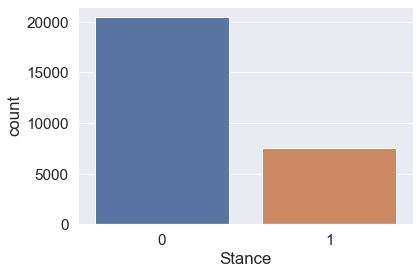

In [494]:
sn.countplot(x=Y_train)
Y_train.value_counts()

In [495]:
rus = RandomUnderSampler(sampling_strategy='not minority', random_state=seed)
X_train, Y_train = rus.fit_resample(X_train, Y_train)
temp_df = X_train
temp_df['Stance'] = Y_train
temp_df = temp_df.sample(frac=1, random_state=seed)
X_train = temp_df.drop(['Stance'], axis=1)
Y_train = temp_df['Stance']

0    7524
1    7524
Name: Stance, dtype: int64

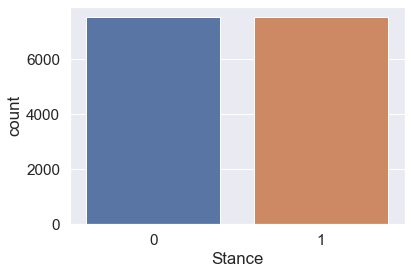

In [496]:
sn.countplot(x=Y_train)
Y_train.value_counts()

### TFIDF vecterisation

In [497]:
# Training tfidf vectoriser
tfidf_vec = pd.concat([X_test['articleBody'], X_train['articleBody']])
tfidf = TfidfVectorizer(decode_error='ignore', lowercase = True, min_df=2, max_features=500)
tfidf.fit(tfidf_vec)

TfidfVectorizer(decode_error='ignore', max_features=500, min_df=2)

In [498]:
dictionary = np.asarray(tfidf.get_feature_names())
print(dictionary[np.random.randint(0,len(dictionary),size=50)])

['state' 'groups' 'woods' 'appears' 'came' 'september' 'arrested' 'staff'
 'known' 'york' 'officer' 'comment' 'children' 'staff' 'claim' 'they'
 'carried' 'wanted' 'amazon' 'wearing' 'blumenthal' 'later' '20'
 'hostages' 'dog' 'kobani' 'woods' 'spoke' 'he' 'caught' 'second'
 'possible' 'called' 'middle' 'white' 'president' 'held' 'youtube'
 'interview' 'love' 'daily' 'media' 'launch' 'took' 'man' 'air'
 'statement' 'francis' 'mosul' 'rumors']


C:\Users\Ice\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [499]:
def stack_tfidf(X):
    header_tfidf = tfidf.transform(X['Headline'].values.astype('U'))
    body_tfidf = tfidf.transform(X['articleBody'].values.astype('U'))
    stacked_tfidf = hstack([header_tfidf, body_tfidf])
    return stacked_tfidf

X_train_tfidf = stack_tfidf(X_train)
X_val_tfidf = stack_tfidf(X_val)
X_test_tfidf = stack_tfidf(X_test)

In [500]:
tfidf_size = X_test.shape
print('tfidf_size:', tfidf_size)

tfidf_size: (14992, 2)


### preparting the scoring model

In [24]:
# Creating the confussion matrix
def plot_confussion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10})# font size
    plt.show()

In [25]:
# Creating the ROC Curve
def plot_roc_curve(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(121)
    ax.set_aspect(1)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### a.1.1: TDIF-SVM

In [26]:
# Building the SVM model
parameters = { 
    'C': [1.0, 10],
    'gamma': [1, 'auto']}
model = GridSearchCV(SVC(kernel='rbf'), parameters, cv=3, n_jobs=-1)
model.fit(X_train_tfidf, Y_train)

GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1.0, 10], 'gamma': [1, 'auto']})

In [27]:
model.best_params_

{'C': 10, 'gamma': 1}

In [28]:
model = model.best_estimator_

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     10956
           1       0.91      0.96      0.94      4036

    accuracy                           0.97     14992
   macro avg       0.95      0.97      0.96     14992
weighted avg       0.97      0.97      0.97     14992



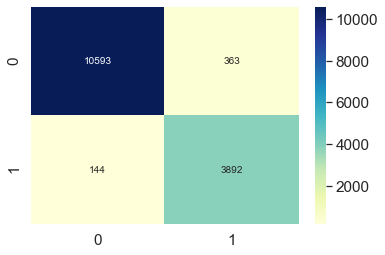

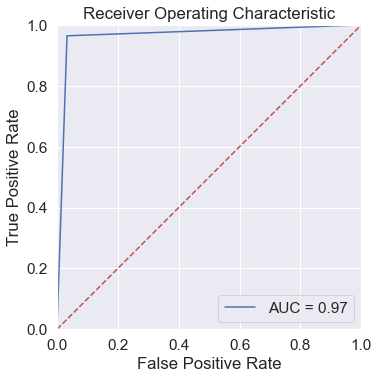

In [29]:
#Predicting the test data
Y_svm = model.predict(X_test_tfidf)
print(metrics.classification_report(Y_test, Y_svm))
plot_confussion_matrix(Y_test, Y_svm)
plot_roc_curve(Y_test, Y_svm)

### a.2.1: TFIDF-LSTM

In [501]:
def prepare_lstm(X, Y):
    X = X.toarray()
    X = X[:, None, :]
    Y = np.array(Y)
    return X, Y

X_train_tfidf, Y_train = prepare_lstm(X_train_tfidf, Y_train)
X_val_tfidf, Y_val = prepare_lstm(X_val_tfidf, Y_val)
X_test_tfidf, Y_test = prepare_lstm(X_test_tfidf, Y_test)

In [502]:
X_train_tfidf.shape

(15048, 1, 1000)

In [503]:
Y_train.shape

(15048,)

Epoch 1/5
1881/1881 [==============================] - 58s 31ms/step - loss: 0.5849 - accuracy: 0.6750 - val_loss: 0.4017 - val_accuracy: 0.8129
Epoch 2/5
1881/1881 [==============================] - 59s 31ms/step - loss: 0.3041 - accuracy: 0.8612 - val_loss: 0.2716 - val_accuracy: 0.8706
Epoch 3/5
1881/1881 [==============================] - 59s 31ms/step - loss: 0.1778 - accuracy: 0.9246 - val_loss: 0.1838 - val_accuracy: 0.9242
Epoch 4/5
1881/1881 [==============================] - 59s 31ms/step - loss: 0.1171 - accuracy: 0.9559 - val_loss: 0.1458 - val_accuracy: 0.9407
Epoch 5/5
1881/1881 [==============================] - 59s 31ms/step - loss: 0.0826 - accuracy: 0.9659 - val_loss: 0.1362 - val_accuracy: 0.9454


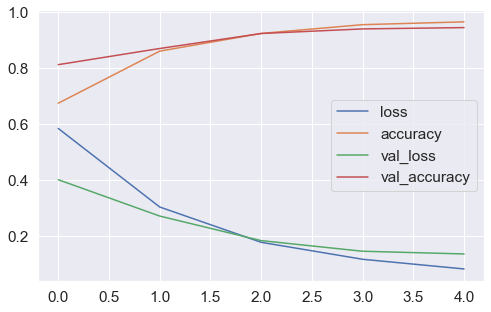

In [504]:
keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

model2 = keras.models.Sequential()
model2.add(keras.layers.LSTM(1000,
                            input_shape=(None, 1000),
                            return_sequences=True))
model2.add(keras.layers.Dropout(0.2))
model2.add(keras.layers.Dense(1, activation='sigmoid'))
model2.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics = ['accuracy'])
history = model2.fit(X_train_tfidf, Y_train, 
                    validation_data=(X_val_tfidf, Y_val),
                    epochs=5, batch_size=8, verbose=1)
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)

In [38]:
Y_lstm = model2.predict_classes(X_test_tfidf)

              precision    recall  f1-score   support

           0      0.980     0.947     0.963     10956
           1      0.868     0.948     0.906      4036

    accuracy                          0.947     14992
   macro avg      0.924     0.947     0.935     14992
weighted avg      0.950     0.947     0.948     14992



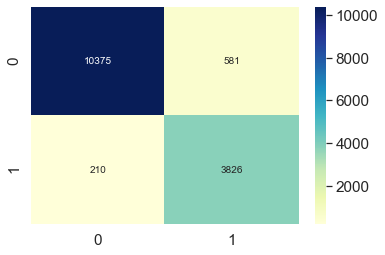

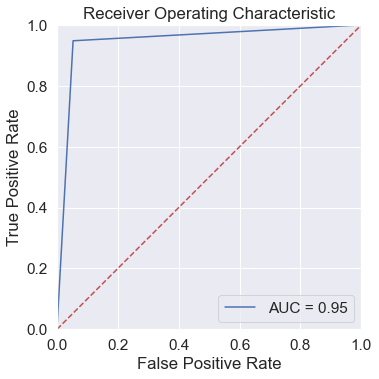

In [39]:
print(metrics.classification_report(Y_test, Y_lstm.reshape(len(Y_lstm)), digits=3))
plot_confussion_matrix(Y_test, Y_lstm.reshape(len(Y_lstm)))
plot_roc_curve(Y_test, Y_lstm.reshape(len(Y_lstm)))

### a.1.2: Bert-SVM

In [41]:
from transformers import BertTokenizer

In [42]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [46]:
def bert_encoder(data):
    encoded_input = []
    for i in data.index:
        encoded_headline = tokenizer.encode(
            text=data['Headline'][i],
            add_special_tokens=True,
            max_length = 30,
            pad_to_max_length=True,
        )
        encoded_body = tokenizer.encode(
            text=data['articleBody'][i],
            add_special_tokens=False,
            max_length = 250,
            pad_to_max_length=True,
        )
        encoded = encoded_headline + encoded_body
        encoded_input.append(encoded)
    encoded_input = np.array(encoded_input)
    return encoded_input

In [47]:
X_train_bert = bert_encoder(X_train)

In [48]:
X_val_bert = bert_encoder(X_val)

In [49]:
X_test_bert = bert_encoder(X_test)

In [50]:
X_train_bert.shape

(15048, 280)

In [51]:
Y_train.shape

(15048,)

In [52]:
# Building the SVM model
parameters = { 
    'C': [1.0, 10],
    'gamma': [1, 'auto']}
model3 = GridSearchCV(SVC(kernel='rbf'), parameters, cv=3, n_jobs=-1)
model3.fit(X_train_bert, Y_train)

GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1.0, 10], 'gamma': [1, 'auto']})

In [53]:
model3.best_params_

{'C': 1.0, 'gamma': 1}

In [54]:
model3 = model3.best_estimator_

              precision    recall  f1-score   support

           0       0.73      1.00      0.85     10956
           1       1.00      0.02      0.04      4036

    accuracy                           0.74     14992
   macro avg       0.87      0.51      0.44     14992
weighted avg       0.81      0.74      0.63     14992



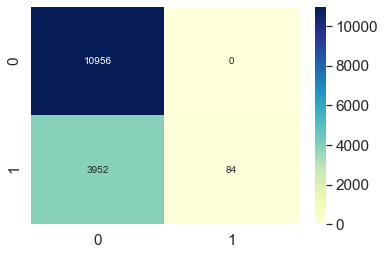

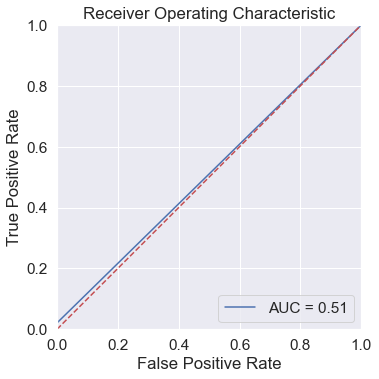

In [55]:
#Predicting the test data
Y_svm = model3.predict(X_test_bert)
print(metrics.classification_report(Y_test, Y_svm))
plot_confussion_matrix(Y_test, Y_svm)
plot_roc_curve(Y_test, Y_svm)

### a.2.2: Bert-LSTM

In [57]:
def nor_bert_vec(x):
    max_vec = x.max()
    x = x/max_vec
    return  x

X_train_bert = nor_bert_vec(X_train_bert)
X_train_bert = nor_bert_vec(X_train_bert)
X_train_bert = nor_bert_vec(X_train_bert)

In [58]:
X_train_bert = X_train_bert[:, None, :]
X_val_bert = X_val_bert[:, None, :]
X_test_bert = X_test_bert[:, None, :]

In [59]:
Y_train = np.array(Y_train)
Y_val = np.array(Y_val)
Y_test = np.array(Y_test)

In [60]:
X_train_bert.shape

(15048, 1, 280)

In [61]:
Y_train.shape

(15048,)

Epoch 1/10
941/941 [==============================] - 4s 4ms/step - loss: 0.6749 - accuracy: 0.5712 - val_loss: 1.2017 - val_accuracy: 0.3932
Epoch 2/10
941/941 [==============================] - 4s 4ms/step - loss: 0.6408 - accuracy: 0.6301 - val_loss: 1.5995 - val_accuracy: 0.4534
Epoch 3/10
941/941 [==============================] - 4s 4ms/step - loss: 0.6031 - accuracy: 0.6687 - val_loss: 0.9791 - val_accuracy: 0.5931
Epoch 4/10
941/941 [==============================] - 3s 4ms/step - loss: 0.5677 - accuracy: 0.7041 - val_loss: 0.8455 - val_accuracy: 0.7078
Epoch 5/10
941/941 [==============================] - 3s 4ms/step - loss: 0.5353 - accuracy: 0.7321 - val_loss: 0.9150 - val_accuracy: 0.6955
Epoch 6/10
941/941 [==============================] - 3s 4ms/step - loss: 0.5136 - accuracy: 0.7468 - val_loss: 0.9003 - val_accuracy: 0.7083
Epoch 7/10
941/941 [==============================] - 3s 4ms/step - loss: 0.4934 - accuracy: 0.7571 - val_loss: 0.7353 - val_accuracy: 0.7474
Epoch 

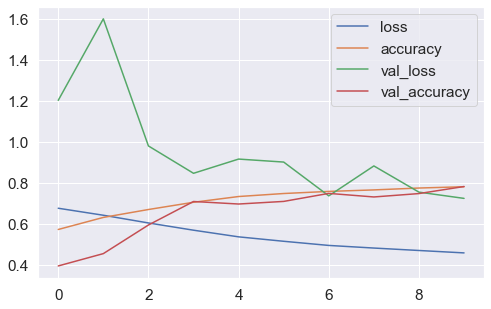

In [69]:
keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

model4 = keras.models.Sequential()
model4.add(keras.layers.LSTM(280,
                            input_shape=(None, 280),
                            return_sequences=True))
model4.add(keras.layers.Dropout(0.1))
model4.add(keras.layers.Dense(1, activation='sigmoid'))
model4.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics = ['accuracy'])
history = model4.fit(X_train_bert, Y_train, 
                    validation_data=(X_val_bert, Y_val),
                    epochs=10, batch_size=16, verbose=1)
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)

In [63]:
Y_lstm = model4.predict_classes(X_test_bert)

              precision    recall  f1-score   support

           0      0.857     0.840     0.848     10956
           1      0.587     0.619     0.602      4036

    accuracy                          0.780     14992
   macro avg      0.722     0.729     0.725     14992
weighted avg      0.784     0.780     0.782     14992



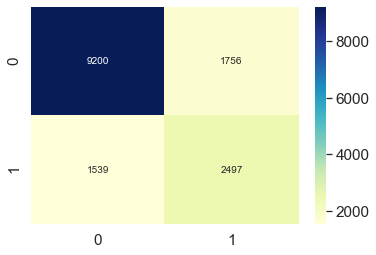

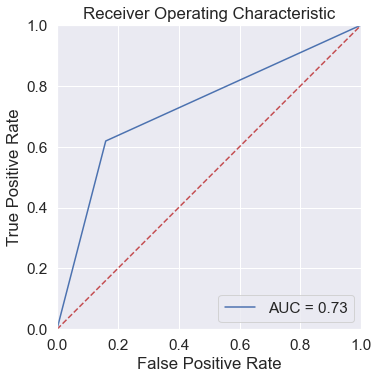

In [64]:
print(metrics.classification_report(Y_test, Y_lstm.reshape(len(Y_lstm)), digits=3))
plot_confussion_matrix(Y_test, Y_lstm.reshape(len(Y_lstm)))
plot_roc_curve(Y_test, Y_lstm.reshape(len(Y_lstm)))

### Task 2 preparation

In [416]:
def prepare_stance(data):
    df = data
    related = {'agree': 1,
               'discuss': 2,
               'disagree': 3,
               'unrelated': 0}
    df['Stance'] = df['Stance'].replace(related)
    df = df.drop(df[df['Stance']==0].index)
    y = df[['Stance']]
    x = df[['Headline', 'articleBody']]
    return x, y

In [420]:
X_train, Y_train = prepare_stance(train)
X_val, Y_val = prepare_stance(val)
X_test, Y_test = prepare_stance(test)

In [422]:
X_train = clean_data(X_train)
X_val = clean_data(X_val)
X_test = clean_data(X_test)

In [423]:
X_train, Y_train = rus.fit_resample(X_train, Y_train)
temp_df = X_train
temp_df['Stance'] = Y_train
temp_df = temp_df.sample(frac=1, random_state=seed)
X_train = temp_df.drop(['Stance'], axis=1)
Y_train = temp_df['Stance']

In [424]:
Y_val = Y_val['Stance']

In [425]:
Y_test = Y_test['Stance']

1    474
2    474
3    474
Name: Stance, dtype: int64

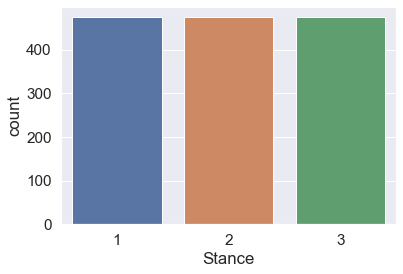

In [426]:
sn.countplot(x=Y_train)
Y_train.value_counts()

In [427]:
Y_train = pd.get_dummies(Y_train)
Y_val = pd.get_dummies(Y_val)
Y_test = pd.get_dummies(Y_test)

In [428]:
X_train_tfidf = stack_tfidf(X_train)
X_val_tfidf = stack_tfidf(X_val)
X_test_tfidf = stack_tfidf(X_test)

### b: TDIF-LSTM

In [429]:
X_train_tfidf, Y_train = prepare_lstm(X_train_tfidf, Y_train)
X_val_tfidf, Y_val = prepare_lstm(X_val_tfidf, Y_val)
X_test_tfidf, Y_test = prepare_lstm(X_test_tfidf, Y_test)

In [430]:
Y_train = Y_train[:,None,:]
Y_val = Y_val[:,None,:]
Y_tets = Y_test[:,None,:]

In [431]:
X_train_tfidf.shape

(1422, 1, 1000)

In [432]:
Y_train.shape

(1422, 1, 3)

Epoch 1/6
178/178 [==============================] - 6s 36ms/step - loss: 0.8835 - accuracy: 0.6174 - val_loss: 0.7292 - val_accuracy: 0.6904
Epoch 2/6
178/178 [==============================] - 6s 34ms/step - loss: 0.5905 - accuracy: 0.7644 - val_loss: 0.7102 - val_accuracy: 0.7065
Epoch 3/6
178/178 [==============================] - 6s 35ms/step - loss: 0.4441 - accuracy: 0.8333 - val_loss: 0.6925 - val_accuracy: 0.7322
Epoch 4/6
178/178 [==============================] - 6s 35ms/step - loss: 0.3646 - accuracy: 0.8594 - val_loss: 0.8504 - val_accuracy: 0.6968
Epoch 5/6
178/178 [==============================] - 6s 34ms/step - loss: 0.3096 - accuracy: 0.8847 - val_loss: 0.8361 - val_accuracy: 0.7231
Epoch 6/6
178/178 [==============================] - 6s 34ms/step - loss: 0.2605 - accuracy: 0.9058 - val_loss: 0.8763 - val_accuracy: 0.7349


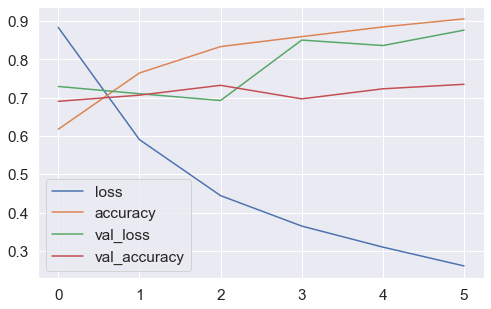

In [433]:
keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

model5 = keras.models.Sequential()
model5.add(keras.layers.LSTM(1000,
                            input_shape=(None, 1000),
                            return_sequences=True))
model5.add(keras.layers.Dropout(0.2))
model5.add(keras.layers.Dense(3, activation='softmax'))
model5.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics = ['accuracy'])
history = model5.fit(X_train_tfidf, Y_train, 
                    validation_data=(X_val_tfidf, Y_val),
                    epochs=6, batch_size=8, verbose=1)
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)

In [434]:
Y_lstm = model5.predict_classes(X_test_tfidf)
Y_lstm = Y_lstm+1
Y_lstm = Y_lstm.reshape(len(Y_lstm))

In [435]:
comparer = test.drop(test[test['Stance']==0].index)
comparer = comparer['Stance']
comparer = np.array(comparer)

              precision    recall  f1-score   support

           1      0.610     0.625     0.618      1113
           2      0.904     0.768     0.830      2686
           3      0.271     0.700     0.391       237

    accuracy                          0.725      4036
   macro avg      0.595     0.698     0.613      4036
weighted avg      0.786     0.725     0.746      4036



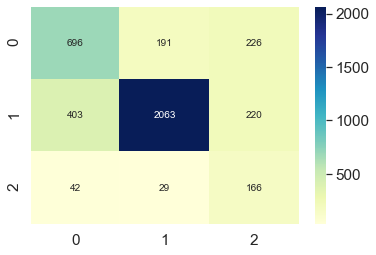

In [440]:
print(metrics.classification_report(comparer, Y_lstm, digits=3))
plot_confussion_matrix(comparer, Y_lstm)

### c: Finalised model

In [528]:
test_fn = test

In [529]:
relation = {'agree': 1,
           'discuss': 2,
           'disagree': 3,
           'unrelated': 0}
test_fn['Stance'] = test_fn['Stance'].replace(relation)

In [531]:
X_test = test_fn[['Headline', 'articleBody']]
X_test = clean_data(X_test)
X_test_tfidf = stack_tfidf(X_test)
X_test_tfidf = X_test_tfidf.toarray()
X_test_tfidf = X_test_tfidf[:, None, :]

<ipython-input-490-7044a453f4ef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Headline'] = [clean_text(i) for i in data['Headline']]
<ipython-input-490-7044a453f4ef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['articleBody'] = [clean_text(i) for i in data['articleBody']]


In [535]:
Y_pred = model2.predict_classes(X_test_tfidf)
Y_pred = Y_pred.reshape(len(Y_pred))

In [537]:
test_fn['prediction'] = Y_pred
test_fn = test2.sort_values(by='prediction')
test_fn

In [539]:
test_fn_related = test_fn.loc[test_fn['prediction']==1]
test_fn_unrelated = test_fn.loc[test_fn['prediction']==0] 

In [545]:
X_test = test_fn_related[['Headline', 'articleBody']]
X_test = clean_data(X_test)
X_test_tfidf = stack_tfidf(X_test)
X_test_tfidf = X_test_tfidf.toarray()
X_test_tfidf = X_test_tfidf[:, None, :]

<ipython-input-490-7044a453f4ef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Headline'] = [clean_text(i) for i in data['Headline']]
<ipython-input-490-7044a453f4ef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['articleBody'] = [clean_text(i) for i in data['articleBody']]


In [546]:
Y_pred_class = model5.predict_classes(X_test_tfidf)

In [549]:
Y_pred_class = Y_pred_class.reshape(len(Y_pred_class))
Y_pred_class = Y_pred_class + 1
test_fn_related['prediction'] = Y_pred_class

In [558]:
test_fn = pd.concat([test_fn_unrelated, test_fn_related], axis=0)
test_fn

,Headline,Body ID,Stance,articleBody,prediction
38740,Militant Group Says It Killed American Journal...,2261,0,From the midweek edition of the Morning Jolt:\...,0
12266,North Korean leader Kim Jong Un had ankle surg...,2489,0,"Sorry to disappoint, fans of Led Zeppelin, but...",0
47085,Kurds fear Isis use of chemical weapon in Kobani,155,0,Comcast allegedly pulled strings to get one of...,0
41519,"Wildest Apple Watch rumor yet: 100,000 apps at...",235,0,Twitter is hopping right now about how Saudi T...,0
39198,British aid worker David Haines beheaded by ISIL,2034,0,When a report went viral that NBC meteorologis...,0
...,...,...,...,...,...
23392,This Is Why Rumors That ISIS Is Crossing The B...,2249,2,The Department of Homeland Security is denying...,2
18369,Islamic State releases video apparently showin...,847,2,"“A Message To America,” a video uploaded Tuesd...",2
16579,HORROR: ISIS Fighters Have Reportedly Contract...,2003,2,The New York Post is reporting this morning th...,2
47615,"BREAKING: ""Brat Pack"" Judd Nelson Found Dead i...",2286,3,In a welcome break from a slow weekend of news...,2


In [559]:
Y_true = test_fn['Stance']
Y_pred_all = test_fn['prediction']

              precision    recall  f1-score   support

           0      0.980     0.947     0.963     10956
           1      0.493     0.575     0.531      1113
           2      0.822     0.741     0.780      2686
           3      0.231     0.671     0.344       237

    accuracy                          0.878     14992
   macro avg      0.632     0.734     0.654     14992
weighted avg      0.904     0.878     0.888     14992



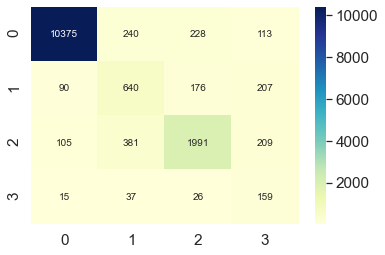

In [560]:
print(metrics.classification_report(Y_true, Y_pred_all, digits=3))
plot_confussion_matrix(Y_true, Y_pred_all)